# Classification: Instant Recognition with Caffe

In this example we'll classify an image with the bundled CaffeNet model (which is based on the network architecture of Krizhevsky et al. for ImageNet).

We'll compare CPU and GPU modes and then dig into the model to inspect features and the output.

### 1. Setup

* First, set up Python, `numpy`, and `matplotlib`.

In [1]:
import sys 
sys.version

'3.5.6 |Anaconda, Inc.| (default, Aug 26 2018, 16:05:27) [MSC v.1900 64 bit (AMD64)]'

In [2]:
'''net.params['conv_concat1_2x'][0].data.shape
a = net.params['conv_concat1_2x'][0].data
b = [a]*512
b = np.concatenate(b,axis = 1 )
print(b.shape)'''

"net.params['conv_concat1_2x'][0].data.shape\na = net.params['conv_concat1_2x'][0].data\nb = [a]*512\nb = np.concatenate(b,axis = 1 )\nprint(b.shape)"

In [3]:
comp_path = r'D:\Medium\Codes\SACNN_application/caffe_blobs/'
import os 
if not os.path.exists(comp_path):
    os.mkdir(comp_path)

In [4]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* Load `caffe`.

In [5]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = 'D:\\Medium\\Codes\\Caffe_build\\caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

* If needed, download the reference model ("CaffeNet", a variant of AlexNet).

In [6]:
import os
if os.path.isfile('ShanghaiTech_part_B.caffemodel'):
    print('CaffeNet found.')
else:
    print('Downloading pre-trained CaffeNet model...')
    !python ../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

CaffeNet found.


### 2. Load net and set up input preprocessing

* Set Caffe to CPU mode and load the net from disk.

In [7]:
caffe.set_mode_cpu()

model_def = 'deploy.prototxt'
model_weights = 'ShanghaiTech_part_B.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [8]:
print(net.params['conv1_1'][0].data.shape)
print(net.params['conv1_2'][0].data.shape)
print(net.params['conv2_1'][0].data.shape)
print(net.params['conv2_1'][1].data.shape)
#[n_out,n_in ,h,w]

(64, 3, 3, 3)
(64, 64, 3, 3)
(128, 64, 3, 3)
(128,)


In [9]:
print(net.params['conv_concat1_2x'][0].data.shape)
print(net.params['p_conv1'][0].data.shape)
print(net.params['conv_concat1_2x'][0].data.sum())

(1024, 1, 2, 2)
(512, 1024, 3, 3)
4096.0


* Set up input preprocessing. (We'll use Caffe's `caffe.io.Transformer` to do this, but this step is independent of other parts of Caffe, so any custom preprocessing code may be used).

    Our default CaffeNet is configured to take images in BGR format. Values are expected to start in the range [0, 255] and then have the mean ImageNet pixel value subtracted from them. In addition, the channel dimension is expected as the first (_outermost_) dimension.
    
    As matplotlib will load images with values in the range [0, 1] in RGB format with the channel as the _innermost_ dimension, we are arranging for the needed transformations here.

In [10]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print('mean-subtracted values:', zip('BGR', mu))

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: <zip object at 0x00000180CEFF7888>


In [32]:
print(mu)

[ 104.00698793  116.66876762  122.67891434]


### 3. CPU classification

* Now we're ready to perform classification. Even though we'll only classify one image, we'll set a batch size of 50 to demonstrate batching.

In [11]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(1,        # batch size
                          3,         # 3-channel (BGR) images
                          768, 1024)  # image size is 227x227

* Load an image (that comes with Caffe) and perform the preprocessing we've set up.

In [12]:
net.params['conv4_3'][1].data

array([  1.23513807e-02,   1.98090523e-02,   8.11119750e-03,
         5.55967912e-03,   6.68451982e-03,   9.81468800e-03,
         2.21421104e-02,   5.10327006e-03,   1.13514699e-02,
        -1.06589019e-03,   6.27596164e-03,   4.52713063e-03,
         3.10604903e-03,   1.52929891e-02,   2.34694332e-02,
         6.56567374e-03,   1.15711549e-02,   2.24544760e-02,
         9.38211009e-03,   2.05250434e-03,  -6.44142623e-04,
         1.36838304e-02,   2.63532135e-03,  -3.30204214e-03,
         1.53635917e-02,   1.43416710e-02,   1.36591010e-02,
         1.40493093e-02,   6.38712721e-04,   7.11917272e-03,
        -6.57251244e-03,  -3.24459327e-03,  -6.52958034e-03,
         1.47340051e-03,   5.30793285e-03,   2.68776342e-03,
        -2.09668232e-03,   1.31769164e-03,   1.20567828e-02,
        -4.57470567e-04,   4.08439292e-03,   0.00000000e+00,
        -1.64402218e-03,   1.93741856e-04,   4.66631213e-03,
         1.56858843e-02,   1.25389183e-02,  -2.64907349e-03,
         1.30673461e-02,

## 哭了，原来整了这么久，caffe默认的读入还是RGB读入

(768, 1024, 3) (768, 1024, 3)
0.0 0.330061 1.0
0 84.165509118 255
float32 uint8


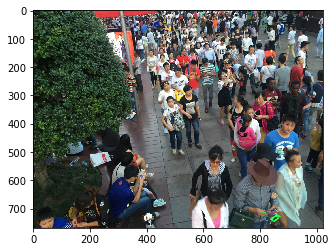

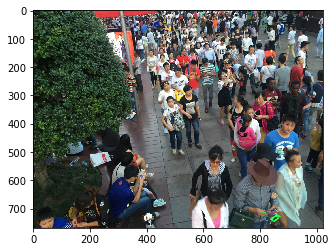

In [24]:
img_comp_path = r'D:\Medium\Codes\SACNN\SaCNN-CrowdCounting-Tencent_Youtu-master\SaCNN-master\data\comb_dataset_v3\part_B_final\train_data\images/IMG_1.jpg'
img1 = caffe.io.load_image(img_comp_path)
img2 = plt.imread(img_comp_path)

print(img1.shape,img2.shape)
print(img1.min(),img1.mean(),img1.max())
print(img2.min(),img2.mean(),img2.max())
print(img1.dtype, img2.dtype )
plt.imshow(img1)
plt.figure()
plt.imshow(img2)
plt.show()

# 完全的RGB读入，但是$\in [0,1]$

那么问题就是变换的顺序是否会有明显影响

从transfomer来看，顺序可能如下

1. 改变最外层的位置
2. 减去均值向量
3. ×255
4. RGB2BGR

对于一个元素a
$$(a-m)\times 255 = 255a - 255m\\
255a -m$$

估计也就是，不可能做第一个式子的步骤

https://www.dazhuanlan.com/2019/12/11/5df0ae65837a7/

从这个链接来看，是
1. 交换通道
2. x255
3. -$\mu$
4. 输入形状

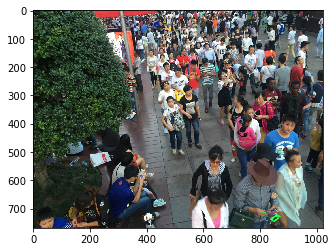

56 56


In [31]:
plt.imshow((img1*255).astype(np.uint8))
plt.show()
print((img1*255).astype(np.uint8)[0,0,1],img2[0,0,1])

In [13]:
image = caffe.io.load_image(r'D:\Medium\Codes\SACNN\SaCNN-CrowdCounting-Tencent_Youtu-master\SaCNN-master\data\comb_dataset_v3\part_B_final\train_data\images/IMG_1.jpg')#caffe_root + 'examples/images/cat.jpg')
print(image.shape)
transformed_image = transformer.preprocess('data', image)
print(transformed_image.shape)

(768, 1024, 3)
(3, 768, 1024)


(3, 768, 1024)


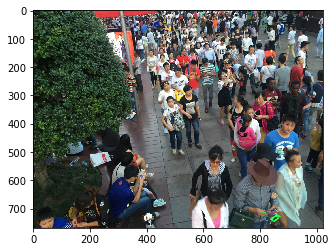

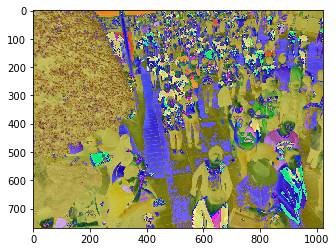

In [14]:
plt.imshow(image)
plt.figure()
print(transformed_image.shape)
img_tt = np.zeros((transformed_image.shape[1],transformed_image.shape[2],transformed_image.shape[0]))
img_tt[:,:,2] = transformed_image[0,:,:]
img_tt[:,:,1] = transformed_image[1,:,:]
img_tt[:,:,0] = transformed_image[2,:,:]
plt.imshow(img_tt)
plt.show()

* Adorable! Let's classify it!

# forward

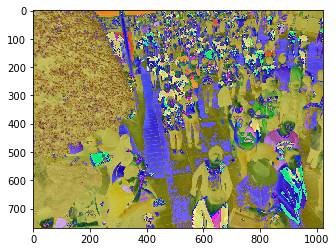

In [15]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

img_tt = np.zeros((transformed_image.shape[1],transformed_image.shape[2],transformed_image.shape[0]))
img_tt[:,:,2] = transformed_image[0,:,:]
img_tt[:,:,1] = transformed_image[1,:,:]
img_tt[:,:,0] = transformed_image[2,:,:]
plt.imshow(img_tt)
plt.show()
### perform classification
output = net.forward()

#output_prob = output#['prob']#[0]  # the output probability vector for the first image in the batch

#print('predicted class is:', output_prob.shape)#.argmax())

In [19]:
blob_keys = net.blobs.keys()
caffe_npy = {}
for key in blob_keys:
    caffe_npy[key] = net.blobs[key].data
np.save(comp_path+'comp_caffe',caffe_npy)

In [76]:
net.blobs['estdmap'].data.shape

(1, 1, 96, 128)

In [72]:
image_input = net.blobs['data'].data
np.save(comp_path ,image_input)

In [73]:
net.params['conv1_1'][0].data.shape#weights
net.params['conv1_1'][1].data.shape#bias

(64,)

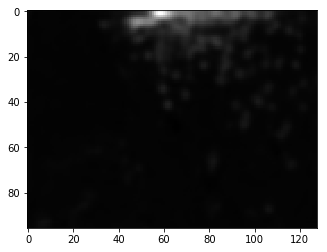

In [18]:
plot_img_test = net.blobs['estdmap'].data
plt.imshow(plot_img_test[0,0,:,:])
plt.show()#从这里彻底可见，这个blobs存储的是一个样本的过了任意层后的所有的数据

(1, 3, 768, 1024)


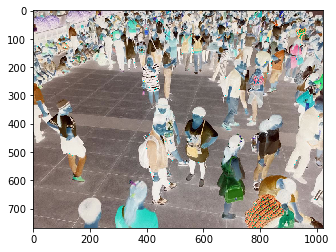

In [41]:
print(net.blobs['data'].data.shape)
img_input = net.blobs['data'].data[0,:,:,:]
img_plot = np.zeros((img_input.shape[1],img_input.shape[2],img_input.shape[0]))
img_plot[:,:,2] = img_input[0,:,:]
img_plot[:,:,1] = img_input[1,:,:]
img_plot[:,:,0] = img_input[2,:,:]
plt.imshow(img_plot)
plt.show()

(1, 1, 96, 128)
208.334


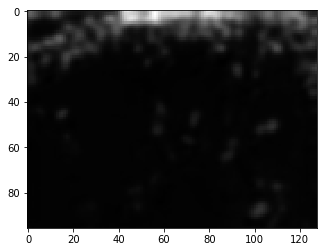

In [42]:
print(output['estdmap'].shape)
plt.imshow(output['estdmap'][0,0,:,:])
print(output['estdmap'].sum())
plt.show()

* The net gives us a vector of probabilities; the most probable class was the 281st one. But is that correct? Let's check the ImageNet labels...

In [33]:
# load ImageNet labels
labels_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
if not os.path.exists(labels_file):
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

print ('output label:', labels[output_prob.argmax()])

'..' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Medium\\Codes\\Caffe_build\\caffe/data/ilsvrc12/synset_words.txt'

* "Tabby cat" is correct! But let's also look at other top (but less confident predictions).

In [10]:
# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]  # reverse sort and take five largest items

print('probabilities and labels:')
zip(output_prob[top_inds], labels[top_inds])

probabilities and labels:


[(0.31243637, 'n02123045 tabby, tabby cat'),
 (0.2379719, 'n02123159 tiger cat'),
 (0.12387239, 'n02124075 Egyptian cat'),
 (0.10075711, 'n02119022 red fox, Vulpes vulpes'),
 (0.070957087, 'n02127052 lynx, catamount')]

* We see that less confident predictions are sensible.

### 4. Switching to GPU mode

* Let's see how long classification took, and compare it to GPU mode.

In [11]:
%timeit net.forward()

1 loop, best of 3: 1.42 s per loop


* That's a while, even for a batch of 50 images. Let's switch to GPU mode.

In [12]:
caffe.set_device(0)  # if we have multiple GPUs, pick the first one
caffe.set_mode_gpu()
net.forward()  # run once before timing to set up memory
%timeit net.forward()

10 loops, best of 3: 70.2 ms per loop


* That should be much faster!

### 5. Examining intermediate output

* A net is not just a black box; let's take a look at some of the parameters and intermediate activations.

First we'll see how to read out the structure of the net in terms of activation and parameter shapes.

* For each layer, let's look at the activation shapes, which typically have the form `(batch_size, channel_dim, height, width)`.

    The activations are exposed as an `OrderedDict`, `net.blobs`.

In [35]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print(layer_name + '\t' + str(blob.data.shape))

AttributeError: 'collections.OrderedDict' object has no attribute 'iteritems'

* Now look at the parameter shapes. The parameters are exposed as another `OrderedDict`, `net.params`. We need to index the resulting values with either `[0]` for weights or `[1]` for biases.

    The param shapes typically have the form `(output_channels, input_channels, filter_height, filter_width)` (for the weights) and the 1-dimensional shape `(output_channels,)` (for the biases).

In [14]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1	(96, 3, 11, 11) (96,)
conv2	(256, 48, 5, 5) (256,)
conv3	(384, 256, 3, 3) (384,)
conv4	(384, 192, 3, 3) (384,)
conv5	(256, 192, 3, 3) (256,)
fc6	(4096, 9216) (4096,)
fc7	(4096, 4096) (4096,)
fc8	(1000, 4096) (1000,)


* Since we're dealing with four-dimensional data here, we'll define a helper function for visualizing sets of rectangular heatmaps.

In [15]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

* First we'll look at the first layer filters, `conv1`

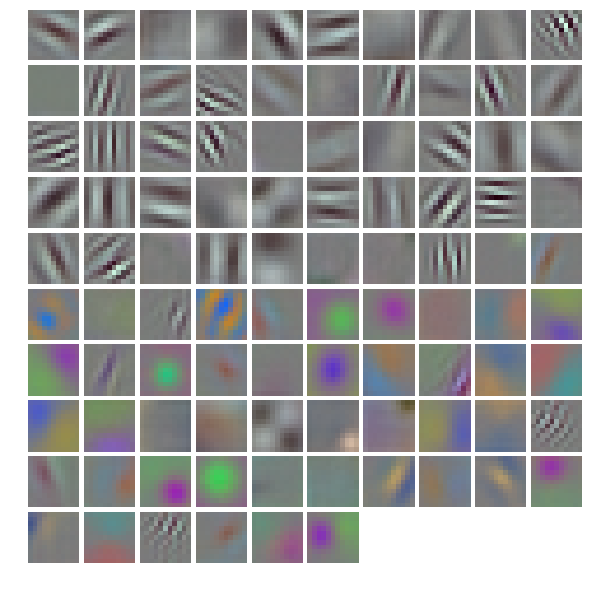

In [16]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

* The first layer output, `conv1` (rectified responses of the filters above, first 36 only)

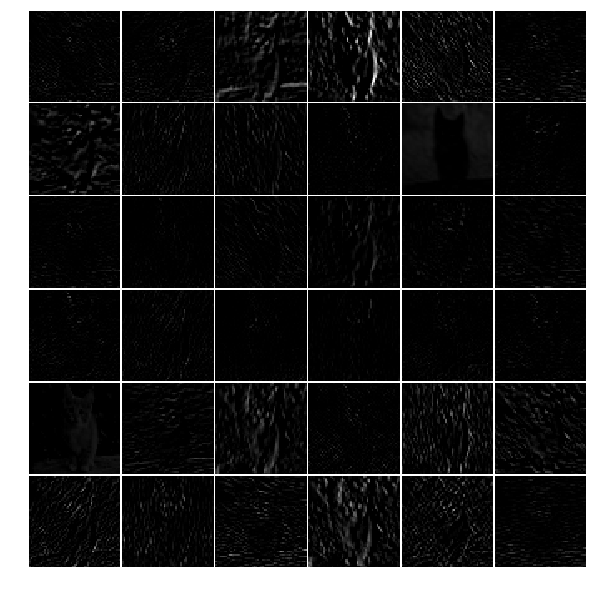

In [17]:
feat = net.blobs['conv1'].data[0, :36]
vis_square(feat)

* The fifth layer after pooling, `pool5`

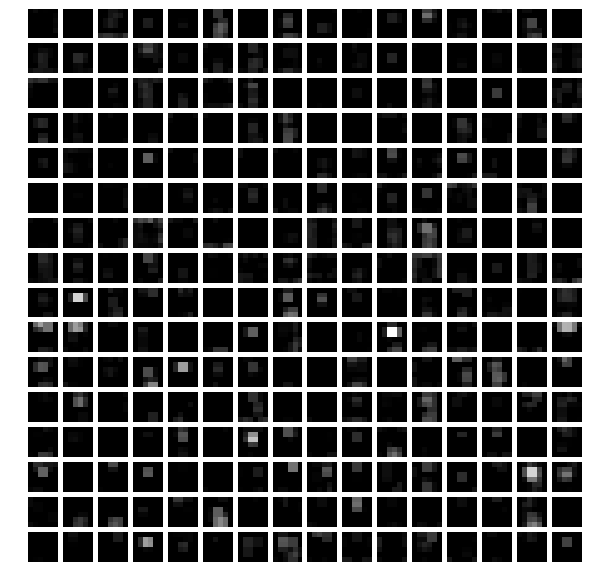

In [18]:
feat = net.blobs['pool5'].data[0]
vis_square(feat)

* The first fully connected layer, `fc6` (rectified)

    We show the output values and the histogram of the positive values

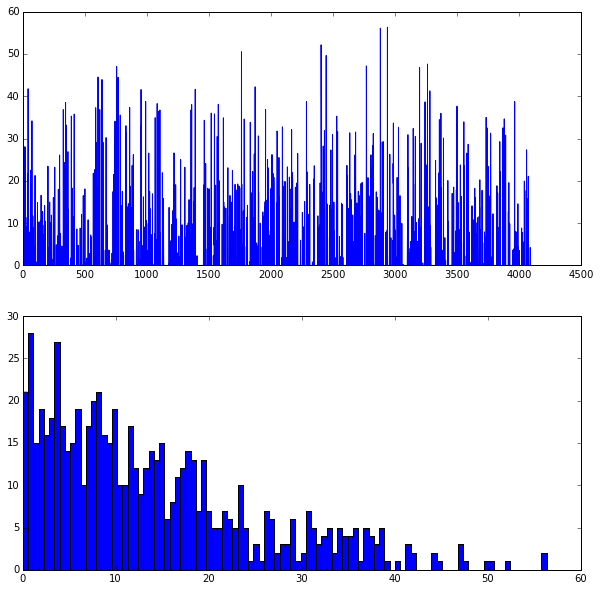

In [19]:
feat = net.blobs['fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

* The final probability output, `prob`

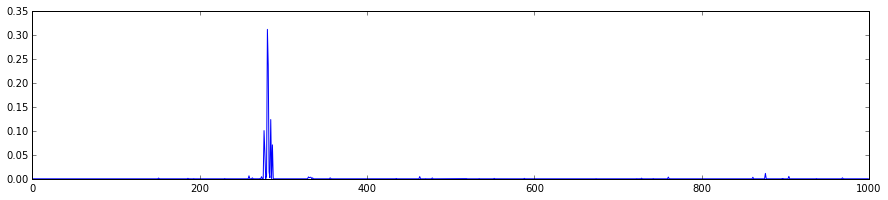

In [20]:
feat = net.blobs['prob'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feat.flat)

Note the cluster of strong predictions; the labels are sorted semantically. The top peaks correspond to the top predicted labels, as shown above.

### 6. Try your own image

Now we'll grab an image from the web and classify it using the steps above.

* Try setting `my_image_url` to any JPEG image URL.

In [155]:
help(net.blobs['data'].reshape)

Help on method reshape:

reshape(...) method of caffe._caffe.Blob instance
    object reshape(tuple args, dict kwds) :
    
        C++ signature :
            object reshape(tuple args, dict kwds)



In [ ]:
# download an image
my_image_url = "..."  # paste your URL here
# for example:
# my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"
!wget -O image.jpg $my_image_url

# transform it and copy it into the net
image = caffe.io.load_image('image.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

# perform classification
net.forward()

# obtain the output probabilities
output_prob = net.blobs['prob'].data[0]

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]

plt.imshow(image)

print('probabilities and labels:')
zip(output_prob[top_inds], labels[top_inds])